# Plane elastoplasticity

In [1]:
import numpy as np
from mpi4py import MPI
import ufl
import basix
import jax.numpy as jnp
from dolfinx import mesh, io, fem
from dolfinx.cpp.nls.petsc import NewtonSolver
from dolfinx.common import list_timings, TimingType
from dolfinx_materials.quadrature_map import QuadratureMap
from dolfinx_materials.solvers import NonlinearMaterialProblem
from dolfinx_materials.python_materials import (
    ElastoPlasticIsotropicHardening,
    LinearElasticIsotropic,
)
from generate_mesh import generate_perforated_plate

In [2]:
E = 70e3
sig0 = 350.0
sigu = 500.0
b = 1e3
elastic_model = LinearElasticIsotropic(E=70e3, nu=0.3)
def yield_stress(p):
    return sig0 + (sigu - sig0) * (1 - jnp.exp(-b * p))
material = ElastoPlasticIsotropicHardening(elastic_model, yield_stress)

In [3]:
N = 30
Eyy = np.linspace(0, 10e-3, N + 1)

In [4]:
Lx = 1.0
Ly = 2.0
R = 0.2
mesh_size = 0.1

In [5]:
generate_perforated_plate(Lx, Ly, R, [mesh_size, 0.2])

Info    : Meshing 1D...
Info    : [  0%] Meshing curve 1 (Line)
Info    : [ 20%] Meshing curve 2 (Line)
Info    : [ 40%] Meshing curve 3 (Line)
Info    : [ 60%] Meshing curve 4 (Line)
Info    : [ 80%] Meshing curve 5 (Ellipse)
Info    : Done meshing 1D (Wall 0.000248287s, CPU 0.000354s)
Info    : Meshing 2D...
Info    : Meshing surface 1 (Plane, Frontal-Delaunay)
Info    : Done meshing 2D (Wall 0.00211004s, CPU 0.002286s)
Info    : 154 nodes 313 elements
Info    : Writing 'plate.geo_unrolled'...
Info    : Done writing 'plate.geo_unrolled'


(<dolfinx.mesh.Mesh at 0x72938ed0b530>,
 <dolfinx.mesh.MeshTags at 0x72938ed6be90>)

In [6]:
with io.XDMFFile(MPI.COMM_WORLD, "mesh.xdmf", "r") as infile:
    domain = infile.read_mesh(mesh.GhostMode.none)

In [7]:
def bottom(x):
    return np.isclose(x[1], 0)

In [8]:
def top(x):
    return np.isclose(x[1], Ly)

In [9]:
top_facets = mesh.locate_entities(domain, 1, top)

In [10]:
facet_tag = mesh.meshtags(
    domain, 1, top_facets, np.full_like(top_facets, 1, dtype=np.int32)
)
ds = ufl.Measure("ds", subdomain_data=facet_tag)

In [11]:
order = 2
deg_quad = 2 * (order - 1)
shape = (2,)
if hypothesis == "plane_strain":
    V = fem.functionspace(domain, ("P", order, shape))
    top_dofs = fem.locate_dofs_geometrical(V, top)
    bottom_dofs = fem.locate_dofs_geometrical(V, bottom)

    uD_b = fem.Function(V)
    uD_t = fem.Function(V)
    bcs = [fem.dirichletbc(uD_t, top_dofs), fem.dirichletbc(uD_b, bottom_dofs)]

    def strain(u):
        return ufl.as_vector(
            [
                u[0].dx(0),
                u[1].dx(1),
                0.0,
                1 / np.sqrt(2) * (u[1].dx(0) + u[0].dx(1)),
                0.0,
                0.0,
            ]
        )
elif hypothesis == "plane_stress":
    Ue = basix.ufl.element("P", domain.basix_cell(), order, shape=(2,))
    Ee = basix.ufl.element("DG", domain.basix_cell(), order - 1)
    V = fem.functionspace(domain, basix.ufl.mixed_element([Ue, Ee]))

    V_u, mapping = V.sub(0).collapse()
    top_dofs = fem.locate_dofs_geometrical((V.sub(0), V_u), top)
    bottom_dofs = fem.locate_dofs_geometrical((V.sub(0), V_u), bottom)

    uD_b = fem.Function(V_u)
    uD_t = fem.Function(V_u)
    bcs = [
        fem.dirichletbc(uD_t, top_dofs, V.sub(0)),
        fem.dirichletbc(uD_b, bottom_dofs, V.sub(0)),
    ]

    def strain(v):
        u, ezz = ufl.split(v)
        return ufl.as_vector(
            [
                u[0].dx(0),
                u[1].dx(1),
                ezz,
                1 / np.sqrt(2) * (u[1].dx(0) + u[0].dx(1)),
                0.0,
                0.0,
            ]
        )
else:
    raise ValueError(
        "Wrong hypothesis type. Only plane_stress/plane_strain is supported."
    )

NameError: name 'hypothesis' is not defined

In [ ]:
du = ufl.TrialFunction(V)
v = ufl.TestFunction(V)
u = fem.Function(V)

In [ ]:
qmap = QuadratureMap(domain, deg_quad, material)
qmap.register_gradient(material.gradient_names[0], strain(u))

In [ ]:
sig = qmap.fluxes["Stress"]
Res = ufl.dot(sig, strain(v)) * qmap.dx
Jac = qmap.derivative(Res, u, du)

In [ ]:
problem = NonlinearMaterialProblem(qmap, Res, Jac, u, bcs)

In [ ]:
newton = NewtonSolver(MPI.COMM_WORLD)
newton.rtol = 1e-6
newton.atol = 1e-6
newton.convergence_criterion = "residual"
newton.report = True
newton.max_it = 50

In [ ]:
file_results = io.XDMFFile(
    domain.comm,
    f"{hypothesis}_plasticity_results.xdmf",
    "w",
)
file_results.write_mesh(domain)
Syy = np.zeros_like(Eyy)
for i, eyy in enumerate(Eyy[1:]):
    uD_t.vector.array[1::2] = eyy * Ly

    converged, it = problem.solve(newton)

    p = qmap.project_on("p", ("DG", 0))
    stress = qmap.project_on("Stress", ("DG", 0))
    file_results.write_function(p, i)
    file_results.write_function(stress, i)

    Syy[i + 1] = fem.assemble_scalar(fem.form(stress[1] * ds(1))) / Lx
    print(Syy)

Solution reached in 1 iterations.
[ 0.         18.96798203  0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.        ]
Solution reached in 1 iterations.
[ 0.         18.96798203 37.93596406  0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.        ]
Solution reached in 1 iterations.
[ 0.         18.96798203 37.93596406 56.90394609  0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.         

In [ ]:
list_timings(domain.comm, [TimingType.wall, TimingType.user])


[MPI_MAX] Summary of timings                                                |  reps  wall avg  wall tot   usr avg   usr tot
---------------------------------------------------------------------------------------------------------------------------
Build dofmap data                                                           |    68  0.000000  0.000000  0.000294  0.020000
Build sparsity                                                              |    90  0.000111  0.010000  0.000000  0.000000
Compute connectivity 1-0                                                    |     1  0.000000  0.000000  0.000000  0.000000
Compute connectivity 2-0                                                    |     1  0.000000  0.000000  0.000000  0.000000
Compute dof reordering map                                                  |    68  0.000000  0.000000  0.000000  0.000000
Compute entities of dim = 1                                                 |     1  0.000000  0.000000  0.000000  0.000000
Compute

In [ ]:
import matplotlib.pyplot as plt

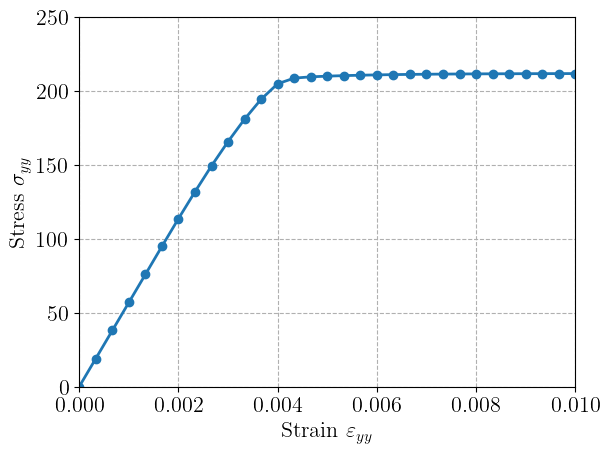

In [ ]:
plt.figure()
plt.plot(Eyy, Syy, "-o")
plt.xlabel(r"Strain $\varepsilon_{yy}$")
plt.ylabel(r"Stress $\sigma_{yy}$")
plt.savefig(f"{material.name}_stress_strain.pdf")
res = np.zeros((len(Eyy), 2))
res[:, 0] = Eyy
res[:, 1] = Syy
np.savetxt(f"{hypothesis}_plasticity_results.csv", res, delimiter=",")